# utterances classification 

In [405]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [406]:
data_dir ='../data/CrisisNLP_labeled_data_crowdflower/2015_Nepal_Earthquake_en'
path = os.path.join(data_dir, '2015_nepal_eq_cf_labels.csv')
ds = pd.read_csv(path)
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3018 entries, 0 to 3017
Data columns (total 10 columns):
_unit_id                          3018 non-null int64
_golden                           3018 non-null bool
_unit_state                       3018 non-null object
_trusted_judgments                3018 non-null int64
_last_judgment_at                 3000 non-null object
choose_one_category               3018 non-null object
choose_one_category:confidence    3018 non-null float64
choose_one_category_gold          18 non-null object
tweet_id                          3018 non-null object
tweet_text                        3018 non-null object
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 215.2+ KB


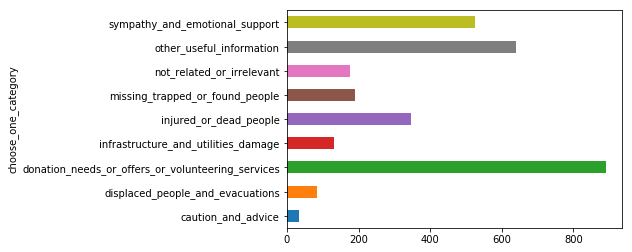

In [407]:
ds.groupby('choose_one_category').size().plot.barh()

In [422]:
ds = ds[ds.choose_one_category.isin( ds.groupby('choose_one_category').size().sort_values(ascending=False).head(3).index)]
ds.shape

(2054, 10)

In [423]:
from sklearn.model_selection import train_test_split

In [424]:
from preprocessor import clean, tokenize
import preprocessor as p
from nltk import wordpunct_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
import re

tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION,p.OPT.RESERVED,p.OPT.SMILEY,p.OPT.NUMBER)

re.split('([A-Z][a-z]+)', '#NepalEarthquake')
re.sub(r'http\S+', '', 'http://google.com test')

' test'

In [425]:

X = ds.tweet_text
#X = X.apply(lambda s: re.sub(r'http\S+', '', s))
X = X.apply(lambda s: clean(s))
X = X.apply(lambda s: ' '.join( re.split('([A-Z][a-z]+)', s)))
X = X.apply(lambda s: ' '.join(tknzr.tokenize( s)))
X = X.apply(lambda s: ' '.join(tokenizer.tokenize(s) ))
X = X.apply(lambda s: clean(s))
y = ds.choose_one_category


In [426]:
X.head().values


array(['Govt asks media houses to exercise restraint while speculating about possible aftershocks after the devastating quake in Nepa Û_',
       'My thoughts and prayers to everyone in Nepal',
       'Prayers For Nepal',
       'LIVE from Airport Kathmandu hrs in conversation with AOK in Studios',
       'Please support helping children in danger from earthquake in Nepal PLS RT'],
      dtype=object)

In [427]:
y.head()

0                             other_useful_information
4                       sympathy_and_emotional_support
5                       sympathy_and_emotional_support
8                             other_useful_information
9    donation_needs_or_offers_or_volunteering_services
Name: choose_one_category, dtype: object

In [428]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape

(1848,)

In [429]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline



In [430]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer='word',lowercase=True, stop_words='english', strip_accents='ascii', min_df=5,max_df=0.8)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [431]:
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [432]:
predicted = text_clf.predict(X_test)

In [433]:
np.mean(predicted == y_test)  

0.7621359223300971

In [434]:
from sklearn import metrics

In [435]:
print(metrics.classification_report(y_test, predicted,))

                                                   precision    recall  f1-score   support

donation_needs_or_offers_or_volunteering_services       0.73      0.90      0.80        86
                         other_useful_information       0.73      0.56      0.64        64
                   sympathy_and_emotional_support       0.86      0.79      0.82        56

                                      avg / total       0.77      0.76      0.76       206

